# 通し課題 : Kickstarter Projects

クラウドファンディングが成功するか否かを予測するコンペだが、このデータセットを利用して、回帰分析を行う。
https://www.kaggle.com/kemical/kickstarter-projects

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format
df = pd.read_csv("./datasets/ks-projects-201801.csv", sep=',',parse_dates=['deadline', 'launched'])
display(df.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00


## 目的変数  
**achievement_rate** : (資金調達の達成率)  
※回帰問題にするために、「ドル換算された集まった資金÷ドル換算された資金調達の目標」で算出する。  
achievement_rate =  usd_pledged_real / usd_goal_real
  
## 説明変数  
  
**name** : (プロジェクトの名前)  
**category** : (カテゴリー)  
**main_category** : (メインカテゴリー)  
**currency** : (サポートに使用される通貨)  
**deadline** : (クラウドファンディングの締め切り)  
**goal** : (資金調達の目標。クリエイターがプロジェクトを完了するために必要な金額)  各国の通貨
**launched** : (開始した日時)  
**pledged** : (集まった資金　※各国の通貨単位)  
**backers** : (バッカーの数)  
**country** : (プロジェクトが開かれた国)  
**usd pledged** : (集まった資金の米ドル換算(kickstarterによる変換))  
**usd_pledged_real** : (集まった資金の米ドル換算(Fixer.io APIからの変換))  
**usd_goal_real** : (資金調達の目標。(Fixer.io APIからの変換))  

**※Backer（バッカー）**  
Kickstarter上のアイディアを実現するためにプロジェクトにお金を提供し、支援する人のこと。  
バッカーになることで、希望者はクリエイターによって設けられた、様々なリワードを受け取ることもできる。

## 前提事項
- クラウドファンディング開始後に得るデータは、説明変数には、使用しない事とする。
    - pledged : (集まった資金)
    - usd pledged : (集まった資金の米ドル換算(kickstarterによる変換))
    - usd_pledged_real : (集まった資金の米ドル換算(Fixer.io APIからの変換))
    - backers : (バッカーの数)  
- 資金調達の目標は、ドル換算された値「usd_goal_real」を利用するため、「goal」は利用しない。

In [2]:
# 目的変数を算出
df['achievement_rate'] = df['usd_pledged_real']*100/df['usd_goal_real']

# 必要のないデータをドロップ
df = df.drop(['pledged','usd pledged','usd_pledged_real','goal','backers','state','name'], axis=1)

# 異常値除外
df = df[df['achievement_rate']<200]

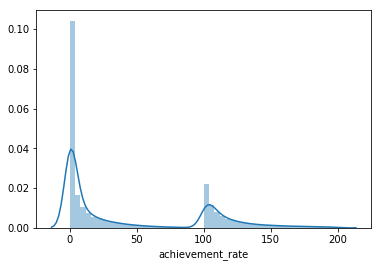

In [3]:
# 資金調達の達成率」を描画
sns.distplot(df['achievement_rate'])

In [4]:
from sklearn.model_selection import train_test_split 

# 全データのうち、20%をテストデータにする
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234) 

## 基礎統計情報マスタを作成する。

80%のトレーニングデータから基礎統計情報を作成する  
20%はモデルにとって未知な想定である検証用データのため、基礎統計に含めないこととする  

In [5]:
# main_category
grouped_main_category = df_train.groupby('main_category')
Statistics_main_category = grouped_main_category.describe()['achievement_rate']
display(Statistics_main_category.sort_values('mean', ascending=False).head())

# category
grouped_category = df_train.groupby('category')
Statistics_category = grouped_category.describe()['achievement_rate']
display(Statistics_category.sort_values('mean', ascending=False).head())

#currency
grouped_currency = df_train.groupby('currency')
Statistics_currency = grouped_currency.describe()['achievement_rate']
display(Statistics_currency.sort_values('mean', ascending=False).head())

#country
grouped_country = df_train.groupby('country')
Statistics_country = grouped_country.describe()['achievement_rate']
display(Statistics_country.sort_values('mean', ascending=False).head())

,count,mean,std,min,25%,50%,75%,max
main_category,,,,,,,,
Dance,2927.00,73.20,53.24,0.00,7.71,101.27,110.00,198.19
Theater,8476.00,71.77,54.08,0.00,6.19,100.90,110.01,199.33
Comics,7240.00,66.14,61.07,0.00,4.33,46.42,116.61,200.00
Music,40177.00,60.13,57.02,0.00,1.00,41.00,108.50,199.80
Art,20908.00,49.97,56.30,0.00,0.54,15.70,104.67,199.92


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Chiptune,26.00,97.89,59.00,0.00,74.70,108.48,132.37,178.40
Anthologies,520.00,87.18,61.71,0.00,20.38,106.35,131.41,200.00
Residencies,57.00,82.25,49.55,0.00,17.67,104.00,110.52,184.00
Typography,69.00,80.98,65.98,0.00,13.27,101.60,138.84,194.94
Dance,1816.00,79.27,51.47,0.00,16.60,102.30,111.37,197.60


,count,mean,std,min,25%,50%,75%,max
currency,,,,,,,,
USD,220261.00,45.74,55.01,0.00,0.42,11.16,103.32,199.99
GBP,25184.00,44.07,55.16,0.00,0.27,9.33,102.20,200.00
HKD,398.00,42.91,53.20,0.00,0.72,13.56,88.83,196.64
SGD,376.00,42.26,52.79,0.00,0.86,12.18,89.19,198.88
JPY,28.00,40.04,46.34,0.00,6.99,17.84,61.86,152.27


,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
"N,0""",2983.00,54.28,56.34,0.00,0.07,16.40,106.25,200.00
US,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
GB,24826.00,43.84,55.10,0.00,0.27,9.13,102.07,200.00
HK,398.00,42.91,53.20,0.00,0.72,13.56,88.83,196.64
SG,376.00,42.26,52.79,0.00,0.86,12.18,89.19,198.88


In [6]:
# 基礎統計情報を結合
df_merged_train  = pd.merge(df_train,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_train  = pd.merge(df_merged_train,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])
df_merged_train.head()

,ID,category,main_category,currency,deadline,launched,country,usd_goal_real,achievement_rate,count,...,75%_currency,max_currency,count_country,mean_country,std_country,min_country,25%_country,50%_country,75%_country,max_country
99498,1505149019,Nature,Photography,USD,2017-02-23,2017-02-16 11:14:42,US,20.00,0.00,8206.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
139186,170701724,Nature,Photography,USD,2017-04-06,2017-03-22 03:41:27,US,1000.00,128.60,8206.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
236241,270933719,Nature,Photography,USD,2016-01-31,2016-01-01 19:42:17,US,2000.00,8.25,8206.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
61859,131461666,Nature,Photography,USD,2015-02-15,2015-01-15 05:05:01,US,9000.00,103.28,8206.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
191804,1975921993,Nature,Photography,USD,2014-12-28,2014-11-28 06:50:33,US,700.00,0.14,8206.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99


In [7]:
# 基礎統計情報を結合
df_merged_test  = pd.merge(df_test,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_test  = pd.merge(df_merged_test,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])
df_merged_test.head()

,ID,category,main_category,currency,deadline,launched,country,usd_goal_real,achievement_rate,count,...,75%_currency,max_currency,count_country,mean_country,std_country,min_country,25%_country,50%_country,75%_country,max_country
105279,1535147626,Drinks,Food,USD,2016-08-01,2016-06-02 02:26:44,US,10.00,0.00,18950.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
308994,643942837,Drinks,Food,USD,2017-09-19,2017-07-21 18:29:22,US,30000.00,0.20,18950.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
171652,1873200410,Drinks,Food,USD,2016-02-13,2016-01-12 21:55:26,US,15000.00,33.84,18950.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
83999,142713419,Drinks,Food,USD,2014-09-05,2014-08-06 05:01:02,US,3400.00,9.32,18950.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99
205203,2045366518,Drinks,Food,USD,2016-09-28,2016-08-29 16:56:23,US,15000.00,2.08,18950.00,...,103.32,199.99,218108.00,45.63,54.98,0.00,0.42,11.11,103.25,199.99


In [8]:
# dropするカラム
drop_columns = ['ID','deadline','launched'
                                    ,'min','max'
                                    ,'min_category','max_category'
                                    ,'currency','min_currency','max_currency'
                                    ,'min_country','max_country']
df_merged_train = df_merged_train.drop(drop_columns, axis=1)
df_merged_test = df_merged_test.drop(drop_columns, axis=1)

# main_category、category、countryはダミー変数を取得する。
df_merged_train = pd.get_dummies(df_merged_train, drop_first=True)
df_merged_test = pd.get_dummies(df_merged_test, drop_first=True)

# 欠損値を除外する。
df_merged_train = df_merged_train.dropna()
df_merged_test = df_merged_test.dropna()

In [9]:
X_train = df_merged_train.drop(['achievement_rate'], axis=1).values
y_train = df_merged_train['achievement_rate'].values
X_test = df_merged_test.drop(['achievement_rate'], axis=1).values
y_test = df_merged_test['achievement_rate'].values

In [10]:
from sklearn.linear_model import LinearRegression

# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

In [11]:
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import r2_score

# MSEを計算
mse = mean_squared_error(y_train, y_pred_train) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_train, y_pred_train) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 決定係数R^2を計算
r2 = r2_score(y_train, y_pred_train) 
print("R^2 = %s"%round(r2, 3))

MSE = 2674.984
MAE = 44.306
RMSE = 51.72
R^2 = 0.099


In [12]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

# MSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred_test) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 決定係数R^2を計算
r2 = r2_score(y_test, y_pred_test) 
print("R^2 = %s"%round(r2, 3))

MSE = 2675.519
MAE = 44.323
RMSE = 51.725
R^2 = 0.097


In [13]:
# 交差検証
from sklearn.model_selection import KFold 

X = pd.concat([df_merged_train.drop(['achievement_rate'], axis=1), df_merged_test.drop(['achievement_rate'], axis=1)]).values
y = pd.concat([df_merged_train['achievement_rate'], df_merged_test['achievement_rate']]).values
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X , y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 44.366

Fold 2
MAE = 44.324

Fold 3
MAE = 44.339

Fold 4
MAE = 44.233

Fold 5
MAE = 44.426

Cross Validation MAE = 44.338


In [14]:
#回帰係数の絶対値が高い順に確認する
coefficient = pd.DataFrame()
coefficient['f_names'] = df_merged_train.drop(['achievement_rate'], axis=1).columns
coefficient['coefficient'] = regr.coef_
coefficient['abs_coefficient'] = abs(coefficient['coefficient'])
sorted_coefficient = coefficient.sort_values('abs_coefficient', ascending=False)
sorted_coefficient

,f_names,coefficient,abs_coefficient
16,25%_currency,209.01,209.01
22,25%_country,-181.15,181.15
206,country_HK,44.14,44.14
209,country_JP,-33.60,33.60
217,country_SG,33.10,33.10
17,50%_currency,-30.00,30.00
107,category_Literary Spaces,23.42,23.42
215,country_NZ,-22.68,22.68
23,50%_country,21.63,21.63
176,category_Webcomics,-20.13,20.13


## 回帰係数の考察
### TOP10
country関連が6件  
currency関連が3件  
category関連が１件
　　

| カラム名                 | 回帰係数 |
|--------------------------|----------|
|             25%_currency |   209.01 |
|              25%_country |  -181.15 |
|               country_HK |    44.14 |
|               country_JP |    -33.6 |
|               country_SG |     33.1 |
|             50%_currency |      -30 |
| category_Literary Spaces |    23.42 |
|               country_NZ |   -22.68 |
|              50%_country |    21.63 |


### WORST10
category関連が6件  
基礎統計のcountが4件


| カラム名              | 回帰係数 |
|-----------------------|----------|
|        category_Bacon |     0.06 |
|  category_Photography |     0.05 |
|          25%_category |     0.04 |
| category_Illustration |     0.01 |
|          75%_category |    -0.01 |
|                 count |        0 |
|        count_category |        0 |
|         count_country |        0 |
|        count_currency |        0 |
|         usd_goal_real |        0 |


## 基礎統計値のうち、countは回帰係数がほぼ0なため、除外する
## 基礎統計値の４分位数の回帰係数が異常に高く、多重共線性が引き起こされている可能性がある

,count,25%,50%,75%,count_category,25%_category,50%_category,75%_category,count_currency,25%_currency,50%_currency,75%_currency,count_country,25%_country,50%_country,75%_country
count,1.00,-0.33,-0.07,0.43,0.27,-0.03,0.12,0.28,0.08,0.07,0.08,0.07,0.06,0.05,0.10,0.08
25%,-0.33,1.00,0.89,0.37,-0.04,0.52,0.53,0.31,0.03,0.04,0.05,0.05,0.03,0.04,0.04,0.05
50%,-0.07,0.89,1.00,0.51,-0.06,0.57,0.66,0.40,0.07,0.07,0.09,0.09,0.06,0.06,0.10,0.09
75%,0.43,0.37,0.51,1.00,0.16,0.29,0.43,0.63,0.12,0.11,0.13,0.13,0.10,0.09,0.14,0.12
count_category,0.27,-0.04,-0.06,0.16,1.00,-0.02,0.01,0.19,0.04,0.04,0.04,0.04,0.02,0.02,0.07,0.04
25%_category,-0.03,0.52,0.57,0.29,-0.02,1.00,0.82,0.43,0.07,0.06,0.07,0.07,0.08,0.07,0.06,0.06
50%_category,0.12,0.53,0.66,0.43,0.01,0.82,1.00,0.53,0.09,0.08,0.10,0.10,0.09,0.08,0.10,0.09
75%_category,0.28,0.31,0.40,0.63,0.19,0.43,0.53,1.00,0.11,0.10,0.12,0.12,0.10,0.09,0.13,0.11
count_currency,0.08,0.03,0.07,0.12,0.04,0.07,0.09,0.11,1.00,0.78,0.84,0.72,0.98,0.76,0.82,0.69
25%_currency,0.07,0.04,0.07,0.11,0.04,0.06,0.08,0.10,0.78,1.00,0.89,0.80,0.76,0.98,0.85,0.76


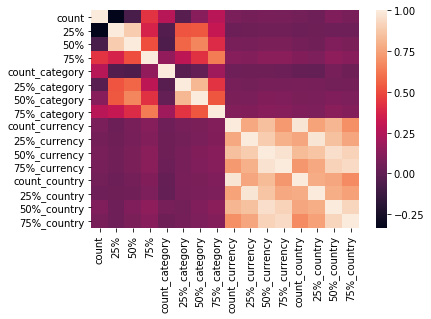

In [15]:
#多重共線性が起きている可能性のある4分位数の相関係数を確認する
corr_columns = ['count','25%','50%','75%'
                                    ,'count_category','25%_category','50%_category','75%_category'
                                     ,'count_currency','25%_currency','50%_currency','75%_currency'
                                    ,'count_country','25%_country','50%_country','75%_country']
display(df_merged_train[corr_columns].corr())
display(sns.heatmap(df_merged_train[corr_columns].corr()))

仮説通り、基礎統計値の４分位数の相関係数が高いことがわかった。
### ４分位数は、一旦25%のみを説明変数として利用する。

In [16]:
#データの読み込み
df = pd.read_csv("./datasets/ks-projects-201801.csv", sep=',',parse_dates=['deadline', 'launched'])

# 目的変数を算出
df['achievement_rate'] = df['usd_pledged_real']*100/df['usd_goal_real']

# 必要のないデータをドロップ
df = df.drop(['pledged','usd pledged','usd_pledged_real','goal','backers','state','name'], axis=1)

# 異常値除外
df = df[df['achievement_rate']<200]

# 全データのうち、20%をテストデータにする
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234) 

# main_category
grouped_main_category = df_train.groupby('main_category')
Statistics_main_category = grouped_main_category.describe()['achievement_rate']

# category
grouped_category = df_train.groupby('category')
Statistics_category = grouped_category.describe()['achievement_rate']

#currency
grouped_currency = df_train.groupby('currency')
Statistics_currency = grouped_currency.describe()['achievement_rate']

#country
grouped_country = df_train.groupby('country')
Statistics_country = grouped_country.describe()['achievement_rate']

# 基礎統計情報を結合
df_merged_train  = pd.merge(df_train,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_train  = pd.merge(df_merged_train,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])

df_merged_test  = pd.merge(df_test,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_test  = pd.merge(df_merged_test,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])


# dropするカラム
drop_columns = ['ID','deadline','launched'
                                    ,'min','max','count','50%','75%'
                                    ,'min_category','max_category' ,'count_category','50%_category','75%_category'
                                    ,'min_currency','max_currency' ,'count_currency','50%_currency','75%_currency'
                                    ,'min_country','max_country' ,'count_country','50%_country','75%_country']
df_merged_train = df_merged_train.drop(drop_columns, axis=1)
df_merged_test = df_merged_test.drop(drop_columns, axis=1)

# main_category、category、countryはダミー変数を取得する。
df_merged_train = pd.get_dummies(df_merged_train, drop_first=True)
df_merged_test = pd.get_dummies(df_merged_test, drop_first=True)

# 欠損値を除外する。
df_merged_train = df_merged_train.dropna()
df_merged_test = df_merged_test.dropna()

X_train = df_merged_train.drop(['achievement_rate'], axis=1).values
y_train = df_merged_train['achievement_rate'].values
X_test = df_merged_test.drop(['achievement_rate'], axis=1).values
y_test = df_merged_test['achievement_rate'].values


In [17]:
# 交差検証
from sklearn.model_selection import KFold 

X = pd.concat([df_merged_train.drop(['achievement_rate'], axis=1), df_merged_test.drop(['achievement_rate'], axis=1)]).values
y = pd.concat([df_merged_train['achievement_rate'], df_merged_test['achievement_rate']]).values
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X , y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 44.366

Fold 2
MAE = 44.326

Fold 3
MAE = 44.339

Fold 4
MAE = 44.233

Fold 5
MAE = 44.426

Cross Validation MAE = 44.338


In [18]:
#回帰係数の絶対値が高い順に確認する
coefficient = pd.DataFrame()
coefficient['f_names'] = df_merged_train.drop(['achievement_rate'], axis=1).columns
coefficient['coefficient'] = regr.coef_
coefficient['abs_coefficient'] = abs(coefficient['coefficient'])
sorted_coefficient = coefficient.sort_values('abs_coefficient', ascending=False)
sorted_coefficient

,f_names,coefficient,abs_coefficient
205,country_FR,20.39,20.39
164,category_Webcomics,-19.98,19.98
216,country_NZ,-19.87,19.87
95,category_Literary Spaces,19.42,19.42
149,category_Taxidermy,-18.99,18.99
38,category_Comics,-17.57,17.57
104,category_Musical,-17.39,17.39
195,currency_SEK,-17.29,17.29
37,category_Comic Books,-16.92,16.92
78,category_Graphic Novels,-16.80,16.80


## 相関係数が高い4分位数を１つに絞ることで、異常に高い回帰係数をなくすことができた
## しかしCross Validation MAEは、44.338から変わらなかった